# Лабораторная работа №4 по теме "Байесовские сети"

```
Студент:
Группа:
Датасет: Zoo Animal Classification
```

# 0. Подготовка данных

In [1]:
import kagglehub
import pandas as pd
from kagglehub import KaggleDatasetAdapter


file_path = "zoo.csv"

data = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "uciml/zoo-animal-classification",
    file_path,
)

class_file_path = "class.csv"

classes = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "uciml/zoo-animal-classification",
    class_file_path,
)


c:\Users\egora\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class_map = dict(zip(classes["Class_Number"], classes["Class_Type"]))


In [3]:
class_map


{1: 'Mammal',
 2: 'Bird',
 3: 'Reptile',
 4: 'Fish',
 5: 'Amphibian',
 6: 'Bug',
 7: 'Invertebrate'}

In [4]:
data.head(10)


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
5,buffalo,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
6,calf,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,1,1
7,carp,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,4
8,catfish,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
9,cavy,1,0,0,1,0,0,0,1,1,1,0,0,4,0,1,0,1


In [5]:
data = data.drop(columns=["animal_name"])


In [6]:
data.columns


Index(['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator',
       'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail',
       'domestic', 'catsize', 'class_type'],
      dtype='object')

In [7]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   hair        101 non-null    int64
 1   feathers    101 non-null    int64
 2   eggs        101 non-null    int64
 3   milk        101 non-null    int64
 4   airborne    101 non-null    int64
 5   aquatic     101 non-null    int64
 6   predator    101 non-null    int64
 7   toothed     101 non-null    int64
 8   backbone    101 non-null    int64
 9   breathes    101 non-null    int64
 10  venomous    101 non-null    int64
 11  fins        101 non-null    int64
 12  legs        101 non-null    int64
 13  tail        101 non-null    int64
 14  domestic    101 non-null    int64
 15  catsize     101 non-null    int64
 16  class_type  101 non-null    int64
dtypes: int64(17)
memory usage: 13.5 KB


# 1. Построение бейслайна

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, log_loss

# 1. Разделяем признаки и таргет
X = data.drop(columns=["class_type"])
y = data["class_type"]

# 2. Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 3. Обучение Naive Bayes (CategoricalNB)
nb = CategoricalNB()
nb.fit(X_train, y_train)

# 4. Предсказания
y_pred = nb.predict(X_test)
y_proba = nb.predict_proba(X_test)

# 5. Метрики
acc_nb = accuracy_score(y_test, y_pred)
ll_nb = log_loss(y_test, y_proba)

print("=== Baseline: Naive Bayes ===")
print(f"Accuracy: {acc_nb:.4f}")
print(f"Log-Likelihood (negative log loss): {-ll_nb:.4f}")


=== Baseline: Naive Bayes ===
Accuracy: 1.0000
Log-Likelihood (negative log loss): -0.0136


# 2. Построение сети и оценка качетсва

## 2.1. Построение сети

In [9]:
train_df = X_train.copy()
train_df["class_type"] = y_train

test_df = X_test.copy()
test_df["class_type"] = y_test

all_classes = sorted(classes["Class_Number"].unique())


In [10]:
from pgmpy.estimators import HillClimbSearch, BIC
from pgmpy.models import DiscreteBayesianNetwork


hc = HillClimbSearch(train_df)
best_model = hc.estimate(scoring_method=BIC(train_df))
model = DiscreteBayesianNetwork(best_model.edges())
model.edges()  # Автоматическая структура


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'hair': 'N', 'feathers': 'N', 'eggs': 'N', 'milk': 'N', 'airborne': 'N', 'aquatic': 'N', 'predator': 'N', 'toothed': 'N', 'backbone': 'N', 'breathes': 'N', 'venomous': 'N', 'fins': 'N', 'legs': 'N', 'tail': 'N', 'domestic': 'N', 'catsize': 'N', 'class_type': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'hair': 'N', 'feathers': 'N', 'eggs': 'N', 'milk': 'N', 'airborne': 'N', 'aquatic': 'N', 'predator': 'N', 'toothed': 'N', 'backbone': 'N', 'breathes': 'N', 'venomous': 'N', 'fins': 'N', 'legs': 'N', 'tail': 'N', 'domestic': 'N', 'catsize': 'N', 'class_type': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'hair': 'N', 'feathers': 'N', 'eggs': 'N', 'milk': 'N', 'airborne': 'N', 'aquatic': 'N', 'predator': 'N', 'toothed': 'N', 'backbone': 'N', 'breathes': 'N'

OutEdgeView([('hair', 'milk'), ('milk', 'class_type'), ('milk', 'eggs'), ('milk', 'catsize'), ('eggs', 'tail'), ('class_type', 'toothed'), ('class_type', 'feathers'), ('class_type', 'backbone'), ('class_type', 'breathes'), ('aquatic', 'fins'), ('aquatic', 'predator'), ('aquatic', 'domestic'), ('fins', 'legs'), ('toothed', 'fins'), ('toothed', 'eggs'), ('backbone', 'legs'), ('backbone', 'tail'), ('legs', 'airborne'), ('breathes', 'aquatic'), ('venomous', 'milk')])

## 2.2. Оценка вероятностей

In [11]:
from pgmpy.estimators import BayesianEstimator


model.fit(train_df, estimator=BayesianEstimator,
          prior_type="BDeu", equivalent_sample_size=10)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'hair': 'N', 'feathers': 'N', 'eggs': 'N', 'milk': 'N', 'airborne': 'N', 'aquatic': 'N', 'predator': 'N', 'toothed': 'N', 'backbone': 'N', 'breathes': 'N', 'venomous': 'N', 'fins': 'N', 'legs': 'N', 'tail': 'N', 'domestic': 'N', 'catsize': 'N', 'class_type': 'N'}


In [12]:
cpt_class = model.get_cpds("class_type")
print(cpt_class)


+---------------+----------------------+----------------------+
| milk          | milk(0)              | milk(1)              |
+---------------+----------------------+----------------------+
| class_type(1) | 0.014285714285714285 | 0.8775510204081631   |
+---------------+----------------------+----------------------+
| class_type(2) | 0.3142857142857143   | 0.020408163265306117 |
+---------------+----------------------+----------------------+
| class_type(3) | 0.09428571428571429  | 0.020408163265306117 |
+---------------+----------------------+----------------------+
| class_type(4) | 0.21428571428571427  | 0.020408163265306117 |
+---------------+----------------------+----------------------+
| class_type(5) | 0.07428571428571429  | 0.020408163265306117 |
+---------------+----------------------+----------------------+
| class_type(6) | 0.13428571428571429  | 0.020408163265306117 |
+---------------+----------------------+----------------------+
| class_type(7) | 0.15428571428571428  |

## 2.3. Визуализация

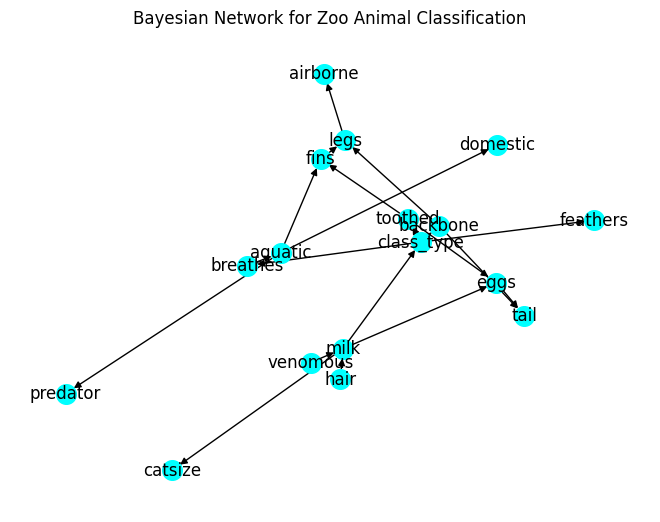

In [13]:
import networkx as nx
import matplotlib.pyplot as plt


nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True,
        node_size=200, node_color="cyan", arrows=True)
plt.title("Bayesian Network for Zoo Animal Classification")
plt.show()


## 2.4. Инференс

In [14]:
from pgmpy.inference import VariableElimination


infer = VariableElimination(model)

query = infer.query(variables=["class_type"], evidence={"milk": 1})

query_values = query.values
query_states = query.state_names["class_type"]


df_res = pd.DataFrame({
    "class_id": query_states,
    "probability": query_values
})

df_res["class_name"] = df_res["class_id"].map(class_map)


print(df_res)


   class_id  probability    class_name
0         1     0.877551        Mammal
1         2     0.020408          Bird
2         3     0.020408       Reptile
3         4     0.020408          Fish
4         5     0.020408     Amphibian
5         6     0.020408           Bug
6         7     0.020408  Invertebrate


## 3. Сравнение с бейслайном

In [15]:
import numpy as np

proba_bn_list = []
pred_bn_list = []

for _, row in test_df.iterrows():
    evidence = row.drop(labels=["class_type"]).to_dict()
    q = infer.query(variables=["class_type"], evidence=evidence)

    q_values = q.values
    q_states = q.state_names["class_type"]

    proba_map = dict(zip(q_states, q_values))

    proba_row = [proba_map.get(c, 0.0) for c in all_classes]
    proba_bn_list.append(proba_row)

    pred_class = all_classes[int(np.argmax(proba_row))]
    pred_bn_list.append(pred_class)

y_pred_bn = np.array(pred_bn_list)
y_proba_bn = np.array(proba_bn_list)

acc_bn = accuracy_score(y_test, y_pred_bn)
lloss_bn = log_loss(y_test, y_proba_bn, labels=all_classes)


results = pd.DataFrame({
    "Model": ["Naive Bayes", "Bayesian Network"],
    "Accuracy": [acc_nb, acc_bn],
    "Log-loss": [ll_nb, lloss_bn]
})

print(results)


              Model  Accuracy  Log-loss
0       Naive Bayes  1.000000  0.013646
1  Bayesian Network  0.961538  0.162752
